In [1]:
"""
Datrevaux Cyprien
2023-06-08
"""

'\nDatrevaux Cyprien\n2023-06-08\n'

### Complete model and first try with sbi :

#### Classic libraries :

In [155]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba
import time
import pandas as pd

# Working directory 
cwd = os.getcwd()
cwd

# Ploting parameters
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [124]:
from tqdm import tqdm 
import seaborn as sns

#### Sbi and torch library :

In [4]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior

from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils

In [5]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [6]:
from lib.report_metrics import posterior_peaks, shrinkage

from lib.report_plots import plot_erp_fitted, plot_erp_ppc, plot_erp_fitted_ppc, plot_true_est_map
from lib.report_plots import plot_zscore_shrinkage, plot_corr, plot_corr_estimations, plot_post_violin, plot_elbo
from lib.report_plots import plot_bar_estimations, plot_post_dist, plot_post_dist_allchains
from lib.report_plots import pair_plots_params, plot_jointpost_estimations, plot_jointpost_offdiag_estimations
from lib.report_plots import plot_degeneracy_timesacels, plot_degeneracy_synapses

# Suppression of the warning :
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
np.seterr(all = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### All Parameter :

In [149]:
Res_dir="Figures/1k/"

In [7]:
# Time series parameters
tend = 200.0
dt=0.1
t0=0.0

ts = np.arange(t0, tend + dt, dt) # Time series array 
nt=ts.shape[0]
nn=9 
x_init=np.zeros((nn)) # Initial condition of every equations

# Parameter of the neuronal population
# intrinsic connexion
g_1=0.42 
g_2=0.76
g_3=0.15
g_4=0.16

tau_e=5.77
h_e=1.63
h_i=27.87
tau_i=7.77

# Input parameter 
stim_init=np.round(ts.shape[0]*0.1) # in ms 
stim_dur=40 # in ms
u=3.94 # Model the afferent connexion  

delta=12.13
alpha=-0.56 # Constante permet de definir la forme de la sigmoïde 


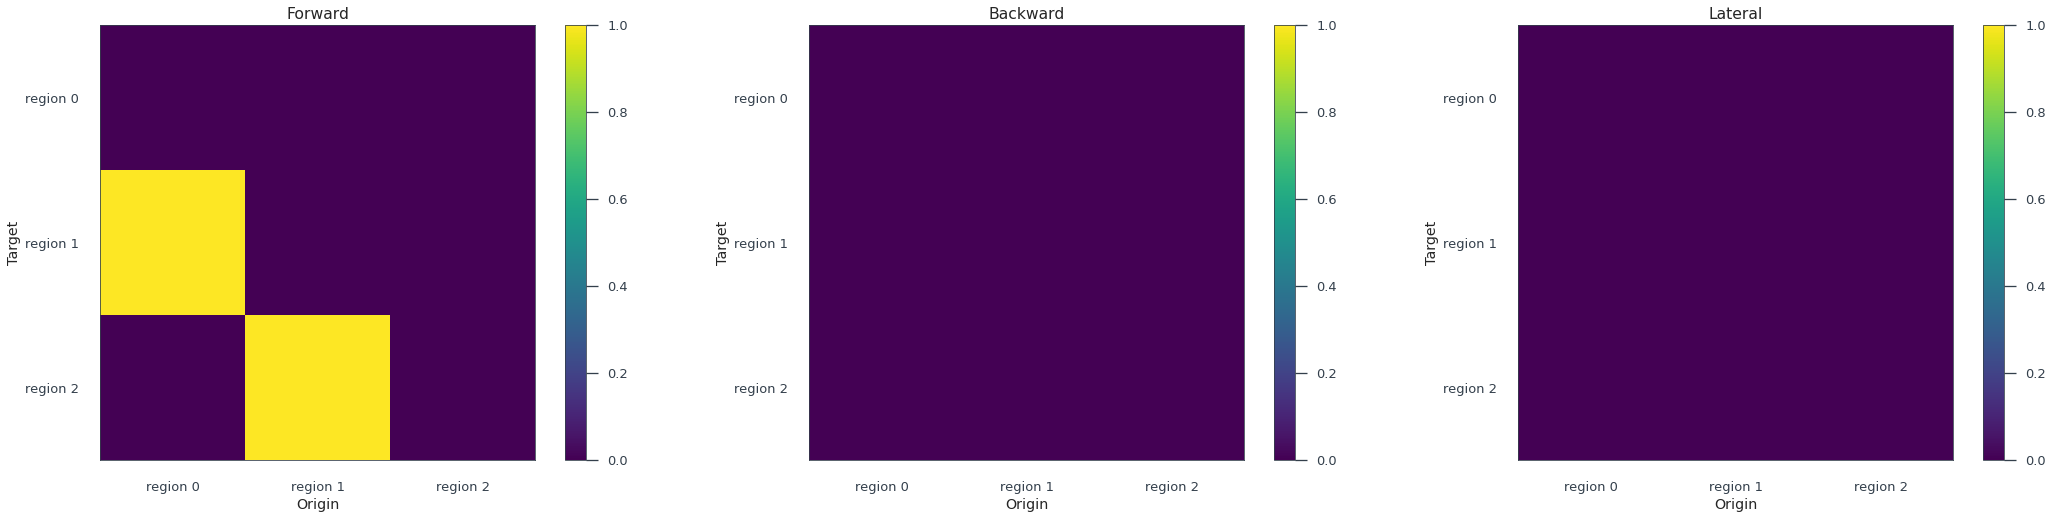

In [163]:
matrice=np.zeros((3,3,3)) # 3 Matrix cube one for every type of projections ("Forward", "Backward", "Backward")

# Connectivity parameter 
matrice[0,1,0]=1
matrice[0,2,1]=1

nr = matrice.shape[2]
region_name=np.arange(0,nr,1)
fig, ax = plt.subplots(1,matrice.shape[0], figsize=(3*12,8))
for i in range(matrice.shape[0]):
    mat=ax[i].imshow(matrice[i],cmap="viridis",vmin=0,vmax=1)
    ax[i].set_xticks(region_name)
    ax[i].set_xticklabels([f"region {int(j)}" for j in region_name])
    ax[i].set_yticks(region_name)
    ax[i].set_yticklabels([f"region {int(j)}" for j in region_name])
    ax[i].set_xlabel("Origin")
    ax[i].set_ylabel("Target")
    fig.colorbar(mat,ax=ax[i])
ax[0].set_title("Forward")
ax[1].set_title("Backward")
ax[2].set_title("Lateral")
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Initial_connectivity_matrix.png"), dpi=400)
plt.show()

### Formatage des parametres input :

In [9]:
constants = np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, alpha, nn])
theta_region = matrice.reshape(-1)
input_par = np.array([stim_init,stim_dur,u])
#theta_region = np.hstack((linear_matrix,input_par))

### Importing the model : 

In [10]:
from DCM_region_model import Sigmodal
from DCM_region_model import DCM_Region #theta, constants, x_init, sig, eps, dt, ts
# DCM_Region = numba.jit(DCM_Region)

In [11]:
region,stim_par=DCM_Region(theta_region,constants,x_init,0,0,dt,ts,input_par)
region=region.reshape(nr,nn,nt)
start_stim=int(stim_par[0]-1)
end_stim=int(stim_par[1]+1)
Stim=stim_par[3:]

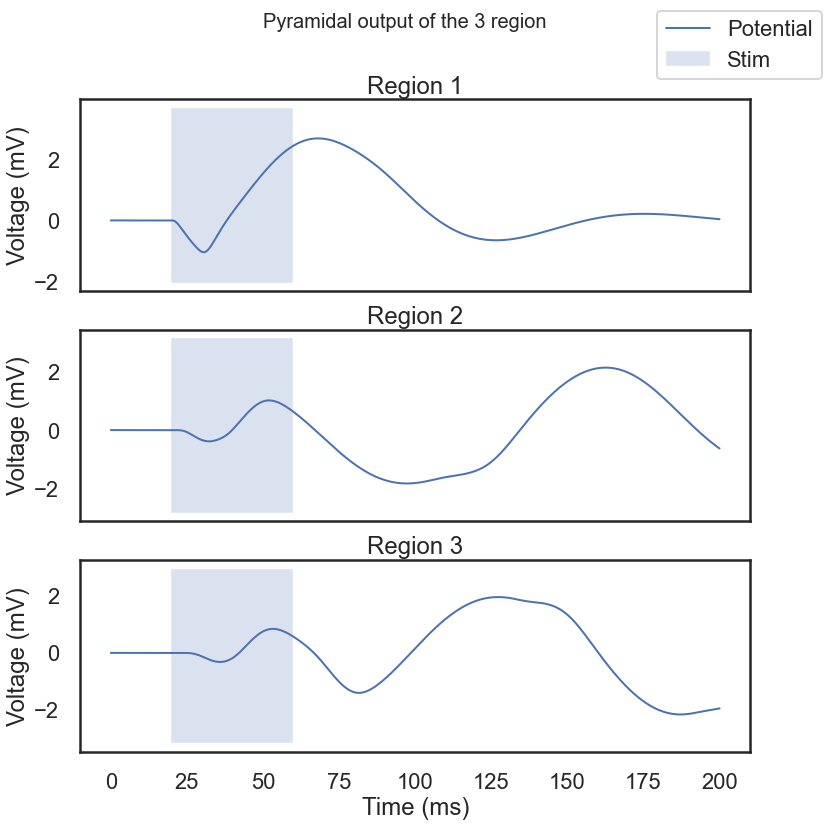

In [150]:
fig ,ax = plt.subplots(region.shape[0],1,figsize=(12,4*3),sharex=True)
for i in range(region.shape[0]):
    ax[i].plot(ts,region[i,8,:],lw=2)
    ax[i].fill_between(ts[start_stim:end_stim],(max(region[i,8,:]+1)),(min(region[i,8,:]-1)),alpha=.2,label="Stim")
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle("Pyramidal output of the 3 region",fontsize=20)
fig.legend(labels=["Potential","Stim"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Pyramidal_output_of_3_regions_1k.png"), dpi=300)
plt.show()

## Trial of the SBI model :

### Simulator Wrapper

In [13]:
@jit(nopython=False)
def DCM_NMM_ERP_simulator_wrapper(params):
    
    params = np.asarray(params)

    # Time series parameters
    tend = 200.0
    dt=0.1
    t0=0.0
    ts = np.arange(t0, tend + dt, dt) # Time series array 
    nt=ts.shape[0]
    nn=int(9)
    nr=int(3) # Number of region
    x_init=np.zeros((nn)) # Initial condition of every equations

    delta=12.13
    alpha=-0.56 # Constante permet de definir la forme de la sigmoïde 
    # Parameter of the neuronal population
    g_1=0.42 
    g_2=0.76
    g_3=0.15
    g_4=0.16
    tau_e=5.77
    h_e=1.63
    h_i=27.87
    tau_i=7.77
    constants = np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, alpha, nn])

    eps=0.
    sig=0.0
    #Stim parameter
    stim_init=np.round(ts.shape[0]*0.1) # in ms 
    stim_dur=40 # in ms
    u=3.94   
    input_par = np.array([stim_init,stim_dur,u])
    Sim_,stim_par_wrapper = DCM_Region(params, constants, x_init, sig, eps, dt, ts,input_par)

    Simulated_ERP=Sim_.reshape(nr,nn,nt)  
    Simulated_ERP_Pyramid=Simulated_ERP[:,8,:]
     
    return Simulated_ERP_Pyramid.reshape(-1)#,stim_par_wrapper

## Data feature :

In [14]:
from DCM_region_features import calculate_summary_statistics

calculate_summary_statistics = numba.jit(calculate_summary_statistics)

In [15]:
_=DCM_NMM_ERP_simulator_wrapper(theta_region)
features_=calculate_summary_statistics(_, features=['higher_moments',  'signal_power', 'signal_envelope', 'autocorlation', 'signal_peaks'])

In [16]:
features_.shape # Shape of 3 x 67, 67 features per regions

(201,)

### 2. Prior over model parameters :
Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [17]:
pmin=0
pmax=1
prior_min = np.ones((nr*nr*3))*pmin # Number of region
prior_max = np.ones((nr*nr*3))*pmax

num_params=len(prior_min)
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
num_sim=1000

In [18]:
mysavepath= os.path.join(cwd+'/'+"Sim_data" , 'simulated_theta_x_dcm_region_allparam_connectivity_matrix_t200msec_'+str(num_sim)+'sims.npz')

def Save_simulations(simulator: Callable, prior,num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)
    np.savez(mysavepath,theta=theta,x=x)

start_time = time.time()

Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, num_simulations=num_sim)

print ("-"*60)
print("--- {} simulation took: %s seconds ---".format(num_sim) % (time.time() - start_time))

### Load simulations and calculate features :
Now we load the simulator output to calculate the data features

In [19]:
loaded_simulations=np.load(mysavepath)
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [20]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)
# Les datas sont de la bonne taille 

theta shape: (1000, 27)
data shape: (1000, 6003)


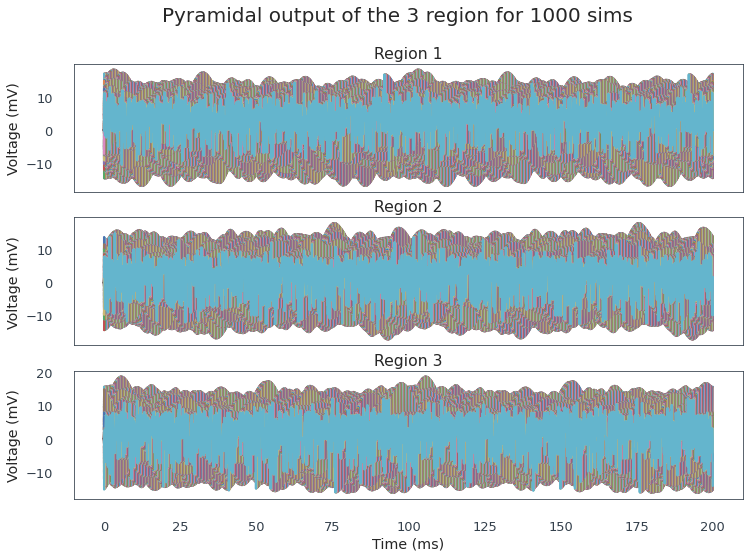

In [162]:
x_sim_plot=x_sim.T.reshape(3,num_sim,int(x_sim.T.shape[0]/3))
fig, ax = plt.subplots(nr,1,figsize=(12,8),sharex=True)
for i in range (nr):
    for j in range(num_sim):
        ax[i].plot(ts,x_sim_plot[i,j,:])
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle(f"Pyramidal output of the 3 region for {num_sim} sims",fontsize=20)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Pyramidal_output_of_3_regions_allsims_1k.png"), dpi=300)
plt.show()

In [22]:
# On le fait que pour la premiere simulation 
if np.isfinite(np.sum(x_sim[0,:]))==True: 
    _=calculate_summary_statistics(x_sim[0,:],features=['higher_moments',  'signal_power', 'signal_envelope', 'autocorlation', 'signal_peaks'])
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 201


In [23]:
theta_features=np.zeros((num_sim,num_params))
x_features=np.zeros((num_sim,num_features))
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (1000, 27)
data frature shape: (1000, 201)


In [24]:
start_time = time.time()
for i in tqdm (range(num_sim)):
       if np.isfinite(np.sum(x_sim[i,:]))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(x_sim[i,:], features=['higher_moments',  'signal_power', 'signal_envelope', 'autocorlation', 'signal_peaks'])
       
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

100%|██████████| 1000/1000 [00:07<00:00, 135.49it/s]

------------------------------------------------------------
--- Calculating features took: 7.411465167999268 seconds ---


In [25]:
theta_features.shape, x_features.shape, print(theta_features.dtype) # Taille correcte

float64


((1000, 27), (1000, 201), None)

In [26]:
# Checking if there are no nan values and removing the values at the index checked
index = np.isnan(x_sim).any(axis=1)
np.count_nonzero(index)
x_features = np.delete(x_features, index, axis=0)
theta_features=np.delete(theta_features, index, axis=0)
theta_features.shape, x_features.shape, print(theta_features.dtype)

# Here we see that the shapes are identical

float64


((1000, 27), (1000, 201), None)

In [27]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([1000, 27])
data feature shape: torch.Size([1000, 201])


### 3. Inference

In [28]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [29]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 42 epochs.------------------------------------------------------------
---training took:  7.517777919769287 seconds ---


### Observed data :

In [30]:
# We use the same data as the one used in the beginning 
observed_data=np.zeros((nr,region.shape[2]))
for i in range(nr):
    observed_data[i]=region[i,8,:]

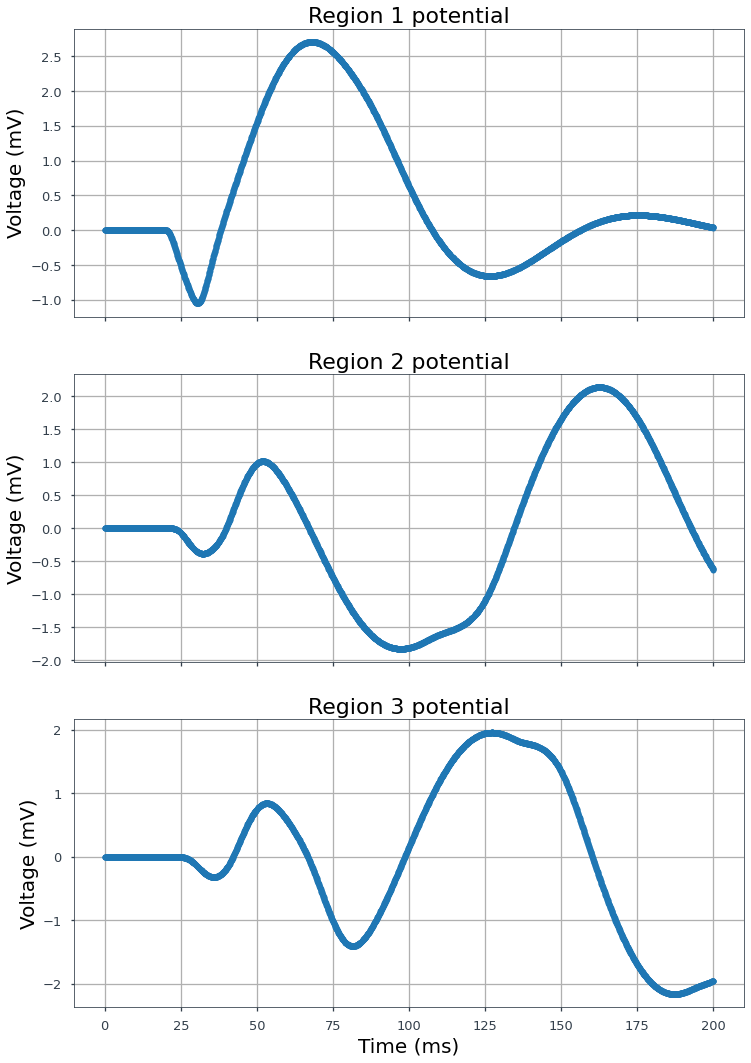

In [31]:
fig, ax = plt.subplots(nr,1,figsize=(12,6*nr),sharex=True)

for i in range(nr):
    ax[i].grid()
    ax[i].plot(ts,observed_data[i],'o', markersize=6, lw=3)
    ax[i].set_ylabel("Voltage (mV)", fontsize=20)
    ax[i].set_title(f"Region {i+1} potential",fontsize=22)
ax[i].set_xlabel("Time (ms)",fontsize=20)
plt.show()

In [32]:
obs_features=calculate_summary_statistics(DCM_NMM_ERP_simulator_wrapper(theta_region), features=['higher_moments',  'signal_power', 'signal_envelope', 'autocorlation', 'signal_peaks'])
obs_features.shape

(201,)

### Posterior for Observed data set :

In [33]:
num_samples=2000
posterior = DirectPosterior(posterior_estimator, prior)

In [34]:
start_time = time.time()

theta_posterior = posterior.sample((num_samples,), obs_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples: 2099it [00:13, 158.15it/s]                          

 Sampling posterior (sec) took: 13.274740934371948


In [35]:
np.mean(np.mean(theta_posterior, axis=0), axis=0), np.std(np.mean(theta_posterior, axis=0), axis=0)

(0.45748714, 0.10448709)

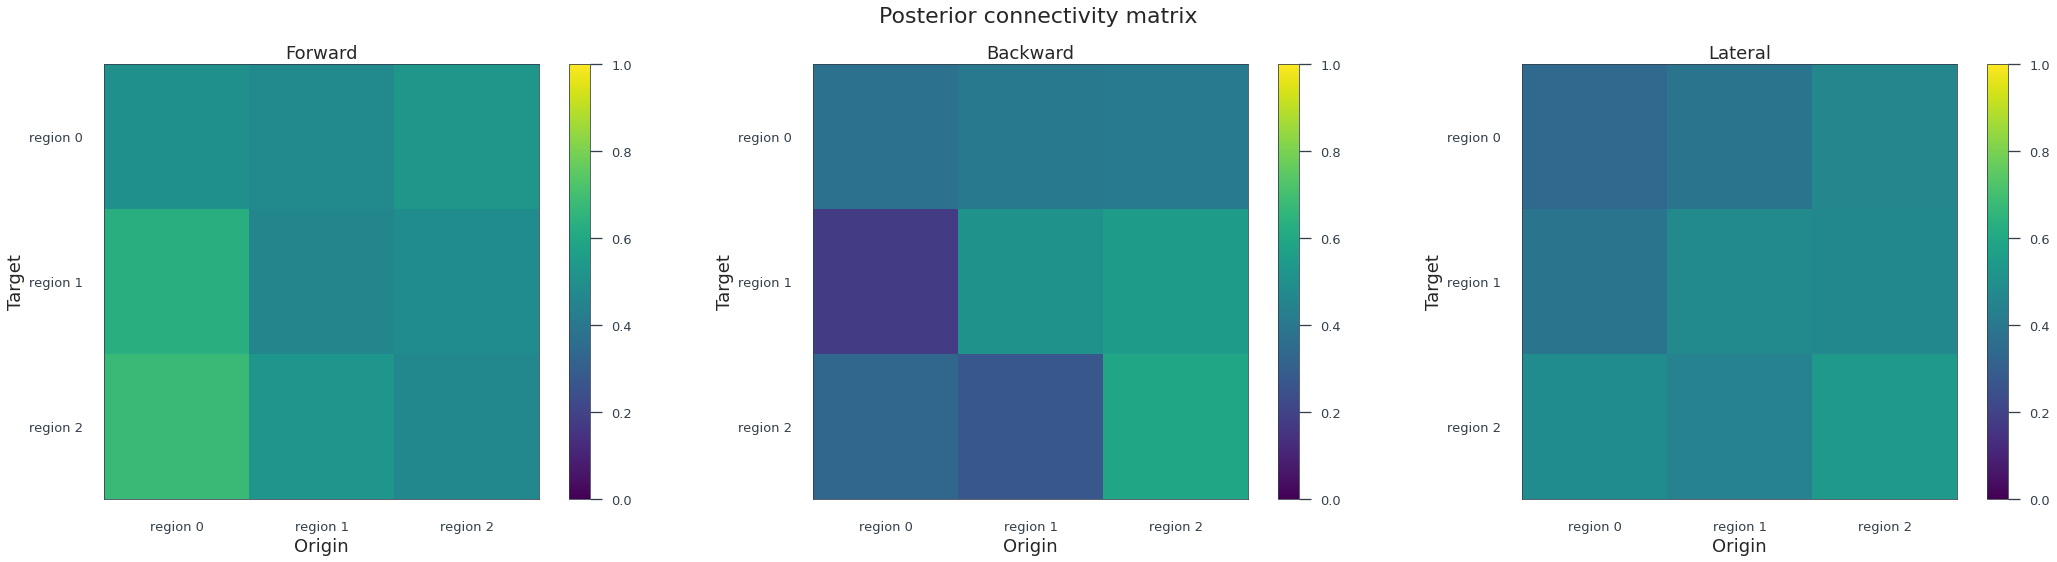

In [165]:
fig, ax = plt.subplots(1,3,figsize=(12*nr,8))
region_name=np.arange(0,nr,1)
for i in range(3):
    mat=ax[i].imshow(np.mean(theta_posterior, axis=0).reshape(3,nr,nr)[i],vmin=pmin,vmax=pmax,cmap="viridis")
    ax[i].set_xticks(region_name)
    ax[i].set_xticklabels([f"region {int(j)}" for j in region_name])
    ax[i].set_yticks(region_name)
    ax[i].set_yticklabels([f"region {int(j)}" for j in region_name])
    ax[i].set_xlabel("Origin",fontsize=18)
    ax[i].set_ylabel("Target",fontsize=18)
    fig.colorbar(mat,ax=ax[i])        
ax[0].set_title("Forward",fontsize=18)
ax[1].set_title("Backward",fontsize=18)
ax[2].set_title("Lateral",fontsize=18)
fig.suptitle("Posterior connectivity matrix",fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Estimated_connectivity_matrix_1k.png"), dpi=400)    

In [37]:
forward_label=[]
backward_label=[]
lateral_label=[]
for i in range (nr):
    for j in range(nr):
        forward_label.append("F Reg " + str(1+i) + str(1+j))
        backward_label.append("B Reg " + str(1+i) + str(1+j))
        lateral_label.append("L Reg " + str(1+i) + str(1+j))
theta_label=forward_label + backward_label + lateral_label
theta_label=np.array(theta_label)

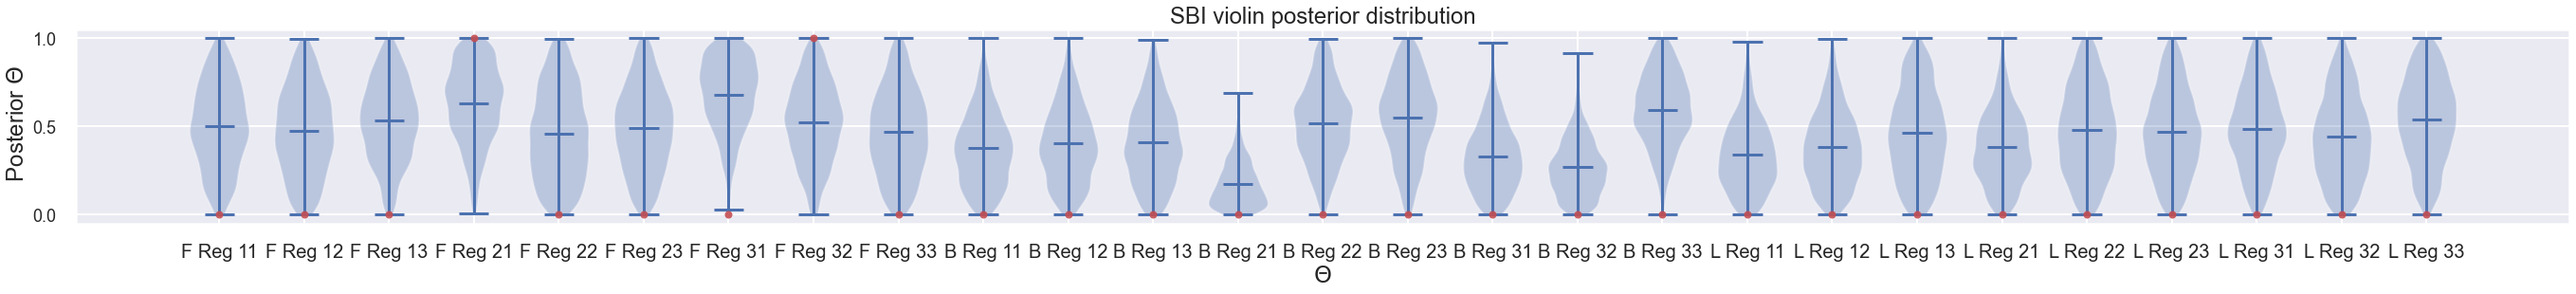

In [197]:
sns.set(font_scale=1.2)
sns.set_context('poster') 
plt.figure(figsize=(12*3.2,4.5))
plot_post_violin (theta_posterior, theta_region, theta_label)
plt.title("SBI violin posterior distribution")
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_violin_posterior_distribution_1k.png"), dpi=800)
plt.show()

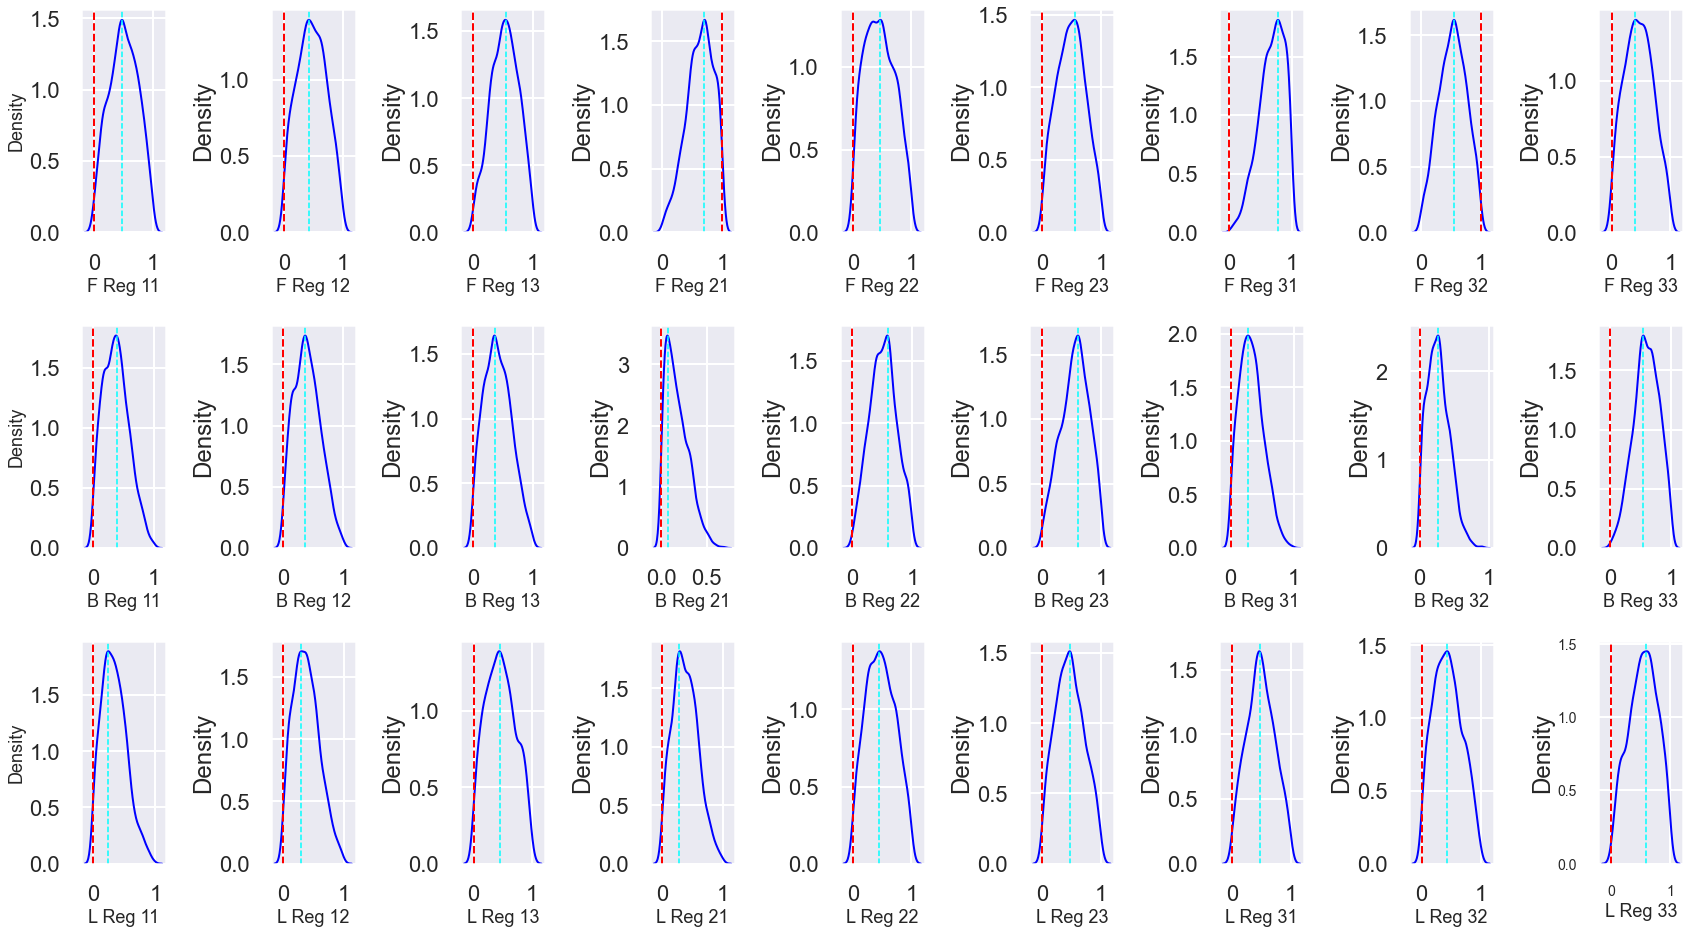

In [174]:
plt.figure(figsize=(12*2,4.5*3))
plot_post_dist(theta_posterior, theta_region, theta_label)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_posterior_distribution_smooth_1k.png"), dpi=800)
plt.show()

In [40]:
# Here the red line représent the true value of the observed data 
# The blue line represent the value calculated by inference

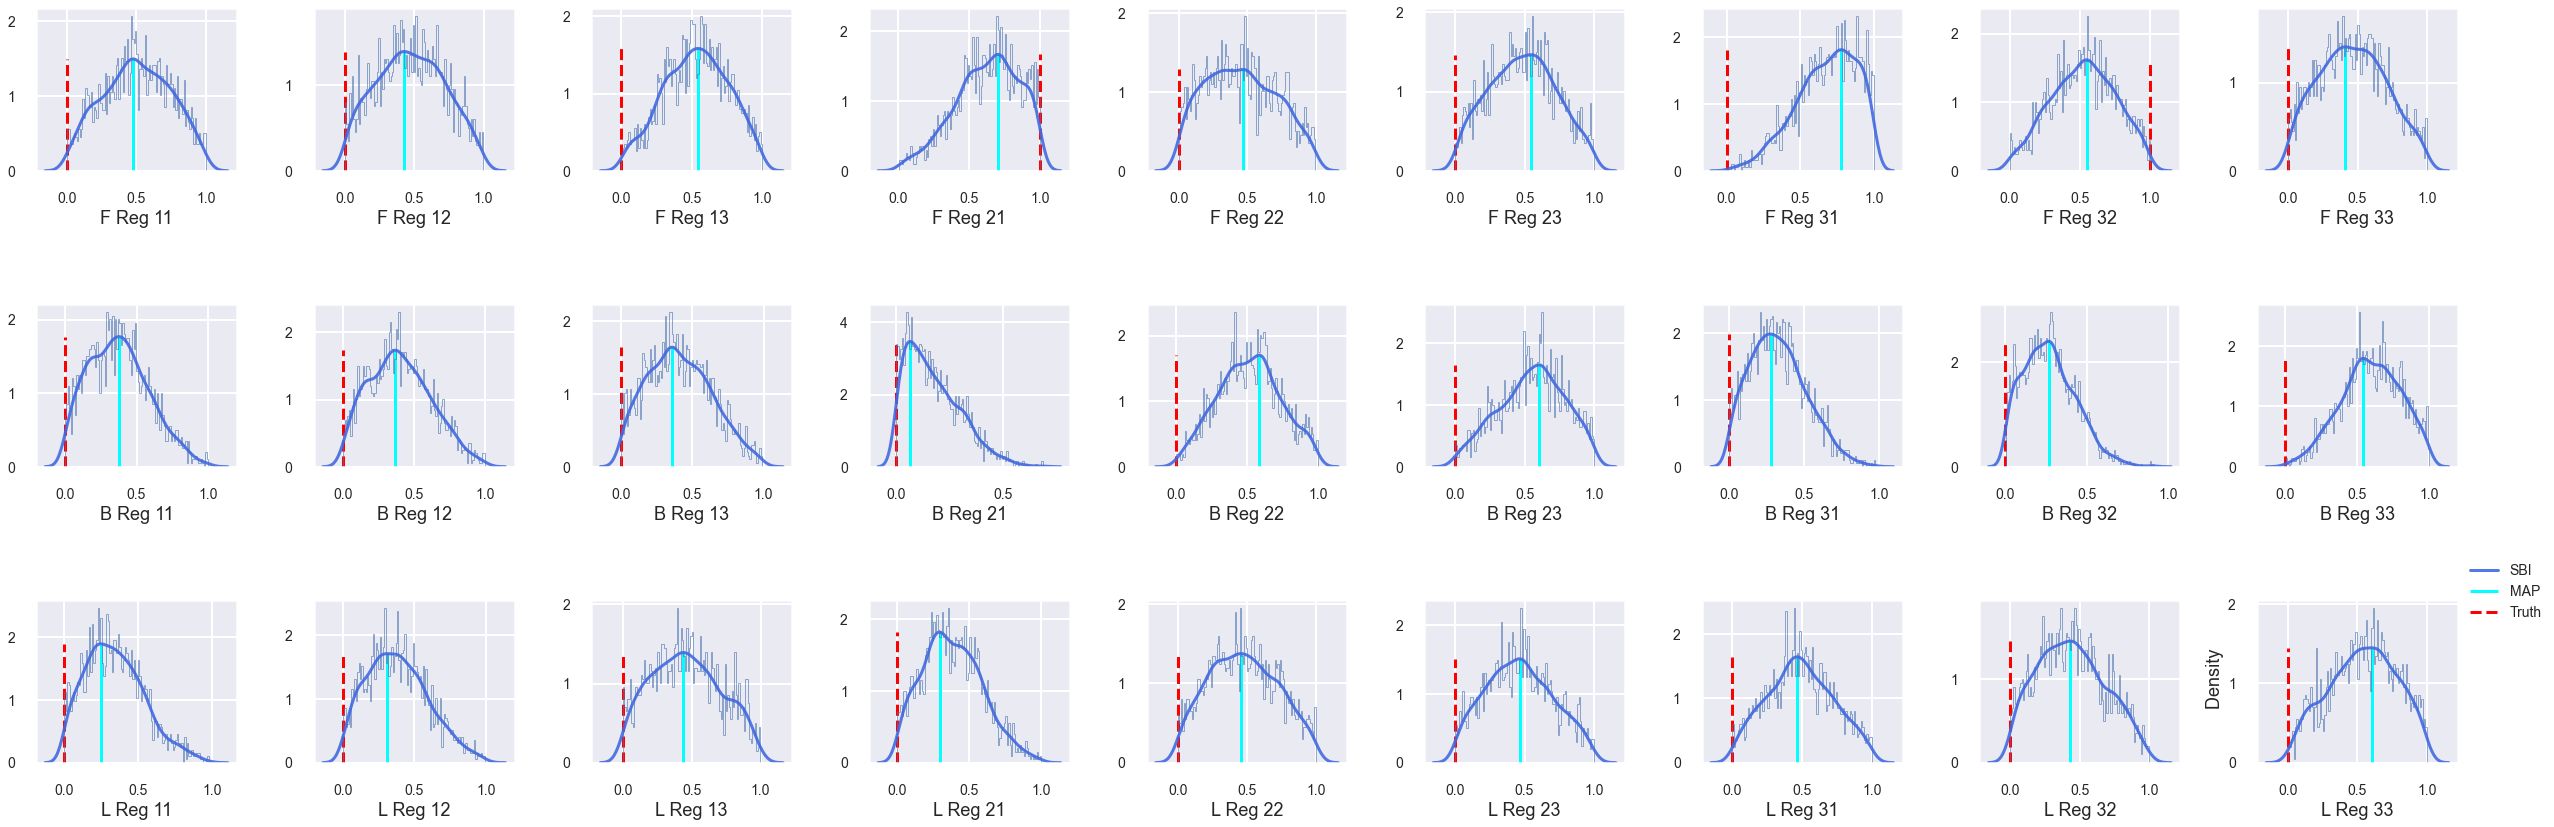

In [175]:
plt.figure(figsize=(12*nr,4*nr))

grid = plt.GridSpec(3, nr*nr)
for i in range(len(theta_label)):
                ax=plt.subplot(3,nr*nr,i+1)
                ax=sns.distplot(theta_posterior[:,i], bins=100, hist=True, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "royalblue", "alpha": 0.9, "lw": 3, "label": "SBI"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "b"},
                 )
                #ax=sns.kdeplot(x=theta[:,i], color='limegreen', lw=2, alpha=0.9)   
                ax.set(ylabel=None)
                x_ = ax.lines[0].get_xdata()
                y_ = ax.lines[0].get_ydata()
                ymax = max(y_)
                xpos = np.argmax(y_, axis=0)
                xmax = x_[xpos]
                plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
                plt.vlines(x=theta_region[i], ymin=0., ymax=y_.max(), colors='red', linestyle='--', label='Truth')
                plt.xlabel((theta_label[i]), fontsize=18); 
                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)    
plt.legend(fontsize=14, bbox_to_anchor=(1, 1.3), frameon=False)
plt.ylabel(' Density', fontsize=18);              
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_posterior_distribution_raw_1k.png"), dpi=800)
plt.show()

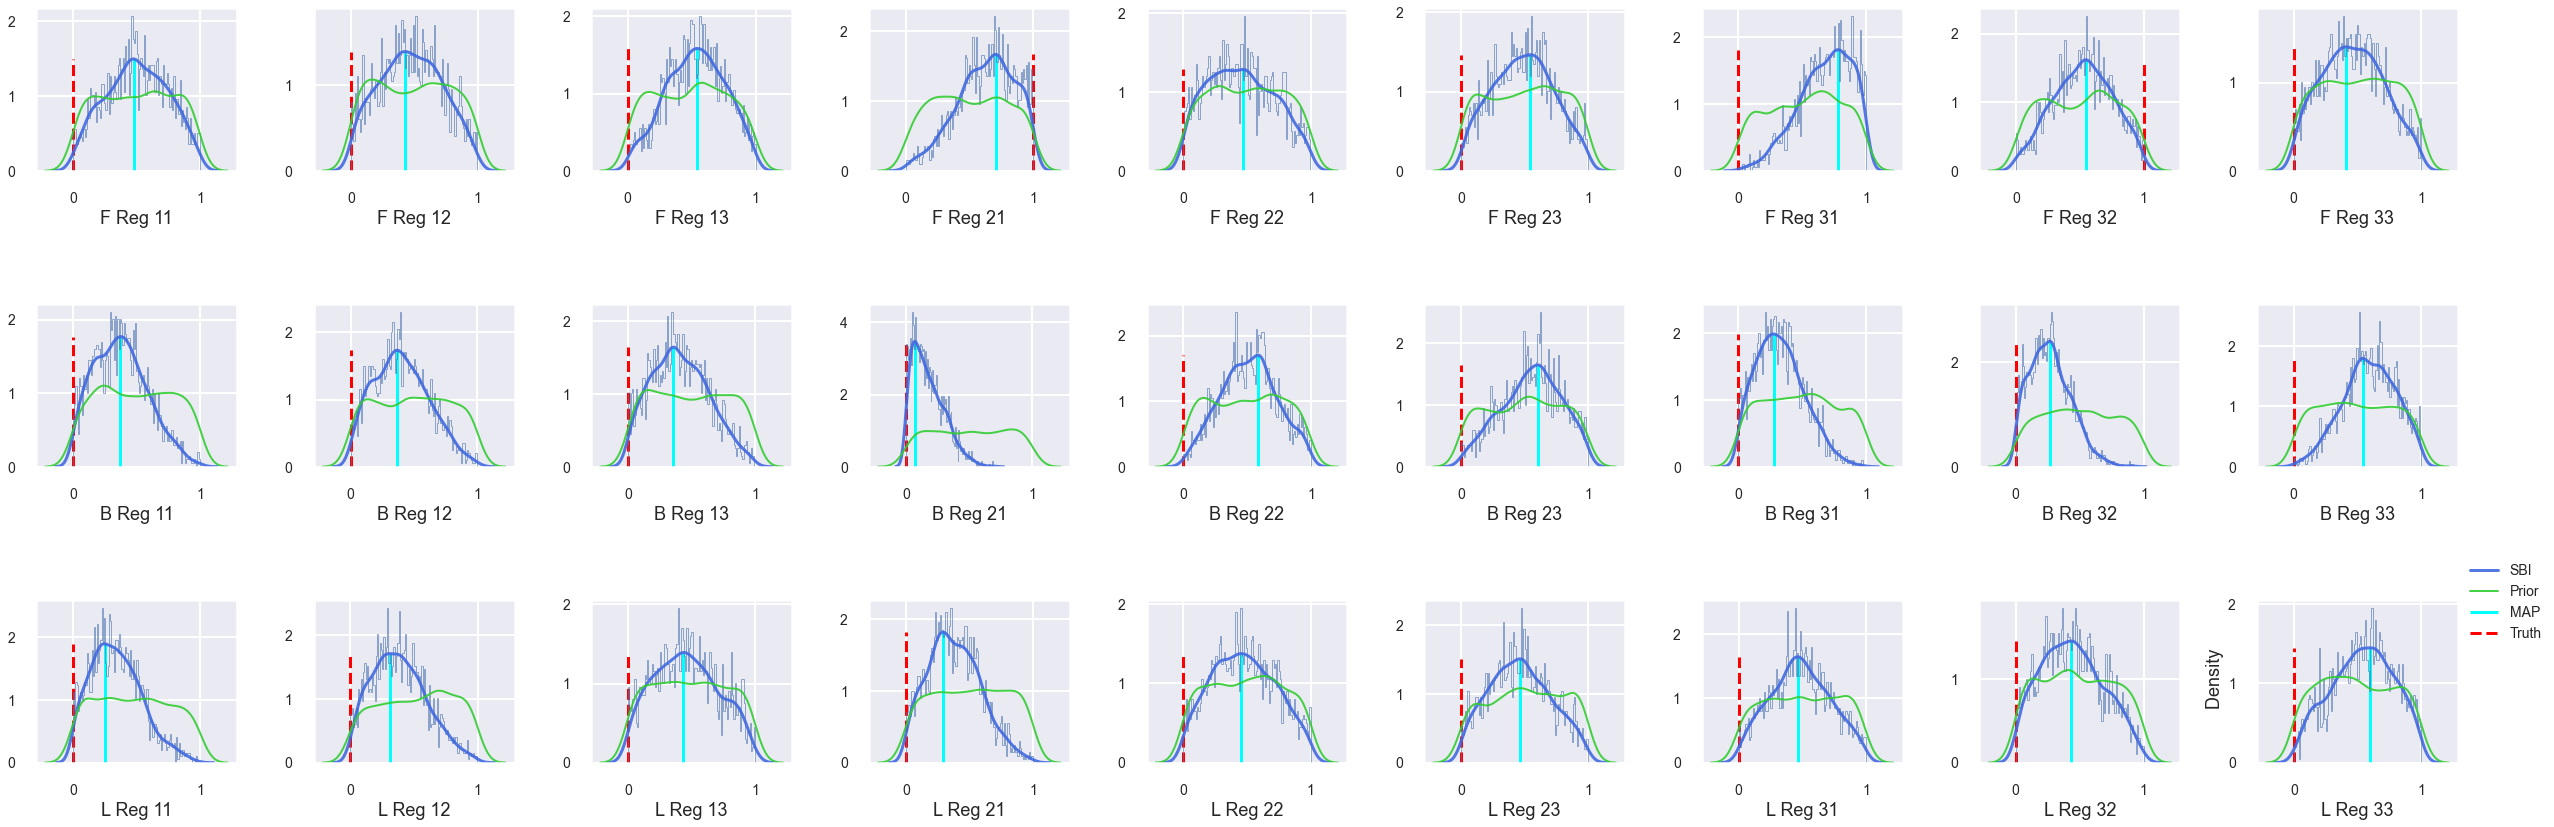

In [42]:
plt.figure(figsize=(12*nr,4*nr))

grid = plt.GridSpec(3, nr*nr)
for i in range (len(theta_label)):
                ax=plt.subplot(3,nr*nr,i+1)
                ax=sns.distplot(theta_posterior[:,i], bins=100, hist=True, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                                  kde_kws={"color": "royalblue", "alpha": 0.9, "lw": 3, "label": "SBI"},
                                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "b"},)
                ax=sns.kdeplot(x=theta[:,i], color='limegreen', lw=2, alpha=0.9, label='Prior')   
                ax.set(ylabel=None)
                x_ = ax.lines[0].get_xdata()
                y_ = ax.lines[0].get_ydata()
                ymax = max(y_)
                xpos = np.argmax(y_, axis=0)
                xmax = x_[xpos]
                plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
                plt.vlines(x=theta_region[i], ymin=0., ymax=y_.max(), colors='red', linestyle='--', label='Truth')
                plt.xlabel((theta_label[i]), fontsize=18); 
                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)   
                
plt.legend(fontsize=14, bbox_to_anchor=(1, 1.3), frameon=False)
plt.ylabel(' Density', fontsize=18);  
plt.tight_layout()
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MAPKDEPosteriorPrior_ERP_ODE_obs1.png"), dpi=800)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MAPKDEPosteriorPrior_ERP_ODE_obs1.svg"), dpi=800)
plt.show()

#### Z score and statistical comparaison :

In [43]:
prior_std =np.sqrt((1/12)*(np.asarray(prior_min)-np.asarray(prior_max))**2)
theta_posterior_mu=np.mean(theta_posterior, axis=0)
theta_posterior_std=np.std(theta_posterior, axis=0)
shrinkage([prior_std], theta_posterior_std)

array([[0.30544523, 0.27797776, 0.3764317 , 0.39892044, 0.21446818,
        0.31528505, 0.49212427, 0.36884608, 0.29582086, 0.4720898 ,
        0.43295262, 0.39418029, 0.80460177, 0.41889509, 0.34551083,
        0.57537671, 0.69131668, 0.48579541, 0.53124257, 0.4573328 ,
        0.24550757, 0.49091084, 0.2649233 , 0.30534438, 0.34222186,
        0.30744118, 0.2992559 ]])

In [54]:
def z_score(true_mean, post_mean, post_std):
    return np.abs((post_mean - true_mean) / post_std)
def shrinkage(prior_std, post_std):
    return 1 - (post_std / prior_std)**2

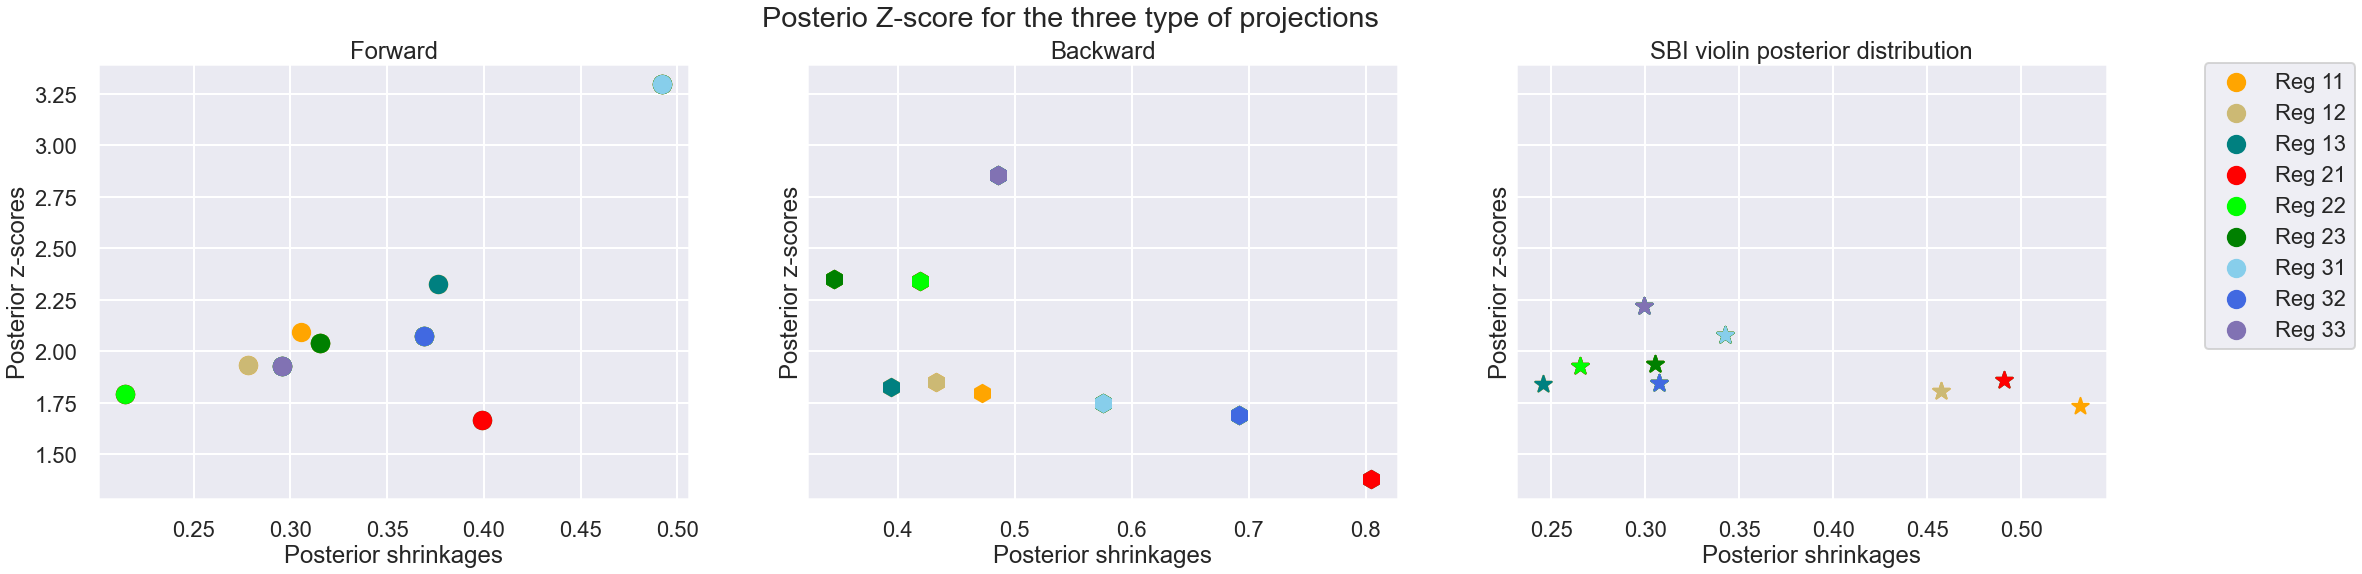

In [178]:
fig, ax = plt.subplots(1,3, figsize=(12*3,8),sharey=True)
label=np.array(['Reg 11', 'Reg 12', 'Reg 13', 'Reg 21', 'Reg 22','Reg 23', 'Reg 31', 'Reg 32', 'Reg 33'])
colors= ['orange', 'y', 'teal',  'red', 'lime', 'green', 'skyblue', 'royalblue',  'm']
marker=["o","h","*"]
for i in range (3):
    for j in range(9):
        ax[i].scatter(shrinkage(prior_std[j+9*i:9*i+9], theta_posterior_std[j+9*i:9*i+9]),
                      z_score(theta_region[j+9*i:9*i+9], theta_posterior_mu[j+9*i:9*i+9], theta_posterior_std[j+9*i:9*i+9]),s=300, marker=marker[i],c=colors[j])
    ax[i].set_xlabel("Posterior shrinkages")
    ax[i].set_ylabel("Posterior z-scores")
fig.suptitle("Posterio Z-score for the three type of projections")
fig.legend(label,bbox_to_anchor=(1, 0.9))
ax[0].set_title("Forward")
ax[1].set_title("Backward")
ax[2].set_title("Lateral")
plt.title("SBI violin posterior distribution")
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_posterior_Zscore_shrinkage_1k.png"), dpi=800)
plt.show()

No handles with labels found to put in legend.


<Figure size 864x576 with 0 Axes>

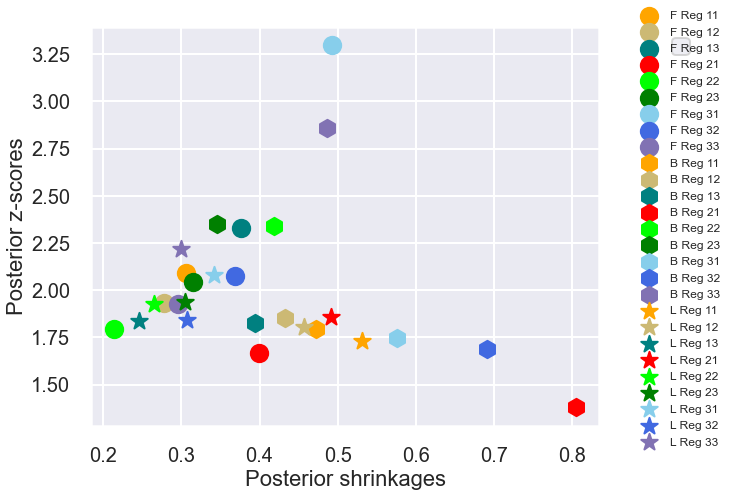

In [45]:
plt.figure(figsize=(12,8))
plot_zscore_shrinkage(theta_region, theta_posterior_mu, theta_posterior_std, prior_std, theta_label)
plt.legend(bbox_to_anchor=(1.2, 1,))
#plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ZscoreShrinkages_DCM_ERP_ODE_obs1.svg"), dpi=800)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ZscoreShrinkages_DCM_ERP_ODE_obs1.png"), dpi=800)

plt.show()

#### Correlation between the different posterior : In our case the weight of the connectivity matrix 

In [46]:
df_posterior = pd.DataFrame(theta_posterior, columns = theta_label)
theta_posterior_corr=df_posterior.corr().to_numpy()

In [47]:
mask = np.zeros_like(theta_posterior_corr)
mask[np.tril_indices_from(mask)] = True

In [48]:
# Peu lisible

plot_corr_estimations(theta_posterior_corr, theta_label)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_CorrPosterior_ERP_ODE_obs1.png"), dpi=800)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_CorrPosterior_ERP_ODE_obs1.svg"), dpi=800)
plt.show()

In [49]:
# Pas super pertient au vu du nombre de variable 

#plot_jointpost_estimations (df_posterior, theta_region)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_PosteriorDistSNS_ERP_ODE_obs1.png"), dpi=800)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_PosteriorDistSNS_ERP_ODE_obs1.svg"), dpi=800)
#plt.show()

In [50]:
# Pas super pertient au vu du nombre de variable 

#plot_jointpost_offdiag_estimations(df_posterior, theta_region)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_PosteriorDistScatter_ERP_ODE_obs1.png"), dpi=800)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_PosteriorDistScatter_ERP_ODE_obs1.svg"), dpi=800)
#plt.show()

### Ploting the feated Data :

#### Fitted method with percentile :

In [115]:
# implementing in the model the best values found from the posterior
sig=0
eps=0
region_fitted,stim_par = DCM_Region(np.percentile(theta_posterior, [50], axis=0)[0,:], constants, x_init, sig, eps, dt, ts,input_par)

In [116]:
region_fitted=region_fitted.reshape(nr,nn,nt)
start_stim=int(stim_par[0]-1)
end_stim=int(stim_par[1]+1)
Stim=stim_par[3:]

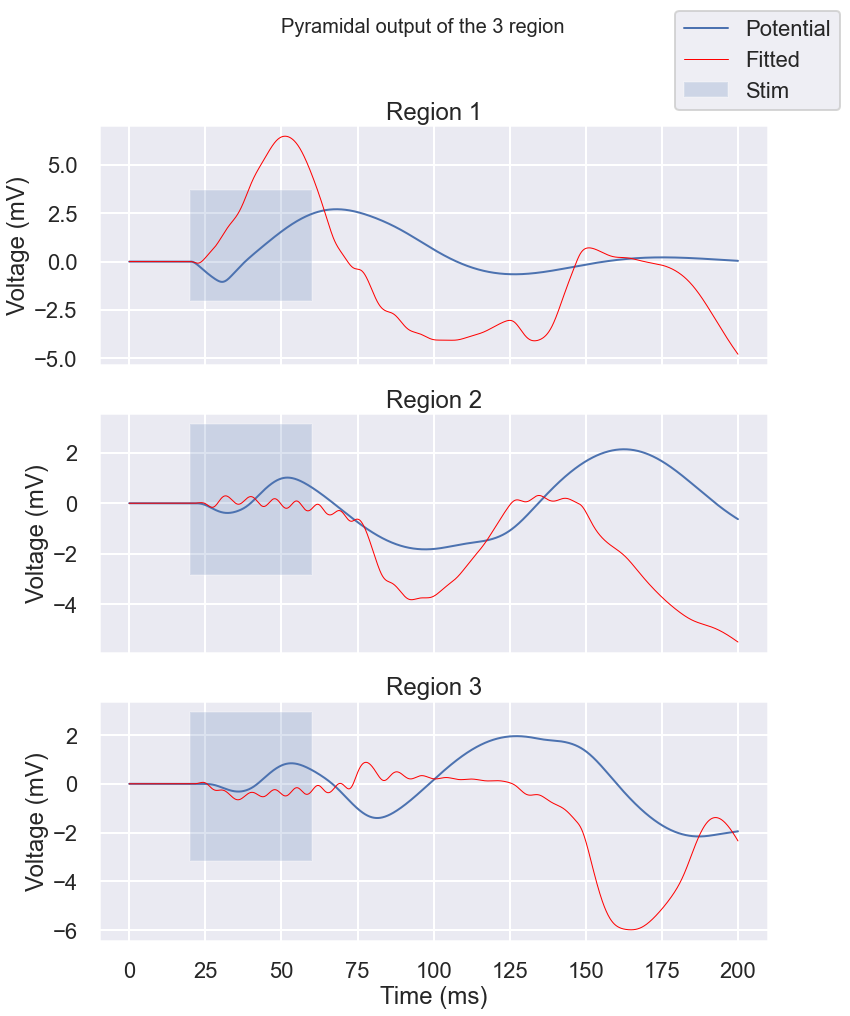

In [193]:
fig ,ax = plt.subplots(region.shape[0],1,figsize=(12,5*3),sharex=True)
for i in range(region.shape[0]):
    ax[i].plot(ts,region[i,8,:],lw=2)
    ax[i].plot(ts,region_fitted[i,8,:],lw=1,color='red')
    ax[i].fill_between(ts[start_stim:end_stim],(max(region[i,8,:]+1)),(min(region[i,8,:]-1)),alpha=.2,label="Stim")
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle("Pyramidal output of the 3 region",fontsize=20)
fig.legend(labels=["Potential","Fitted","Stim"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_percentille_fitted_3regions_1k.png"), dpi=800)
plt.show()

#### Fitted with the mean of theta posterior :

In [189]:
mean_theta_post=np.zeros(theta_posterior.shape[1])
for i in range (len(mean_theta_post)):
    mean_theta_post[i]=np.mean(theta_posterior[:,i])
mean_theta_post

array([0.50291348, 0.47443613, 0.53055555, 0.6270113 , 0.45859125,
       0.48757288, 0.67856264, 0.52407151, 0.46683896, 0.37672606,
       0.40243968, 0.41065106, 0.1760181 , 0.51451451, 0.54932755,
       0.32861018, 0.27076155, 0.59139466, 0.3422702 , 0.38415474,
       0.46110332, 0.38326561, 0.47702539, 0.46653152, 0.48688886,
       0.44322455, 0.53668982])

In [190]:
# implementing in the model the best values found from the posterior
sig=0
eps=0
region_meanfit,stim_par = DCM_Region(mean_theta_post, constants, x_init, sig, eps, dt, ts,input_par)
region_meanfit=region_meanfit.reshape(nr,nn,nt)
start_stim=int(stim_par[0]-1)
end_stim=int(stim_par[1]+1)
Stim=stim_par[3:]

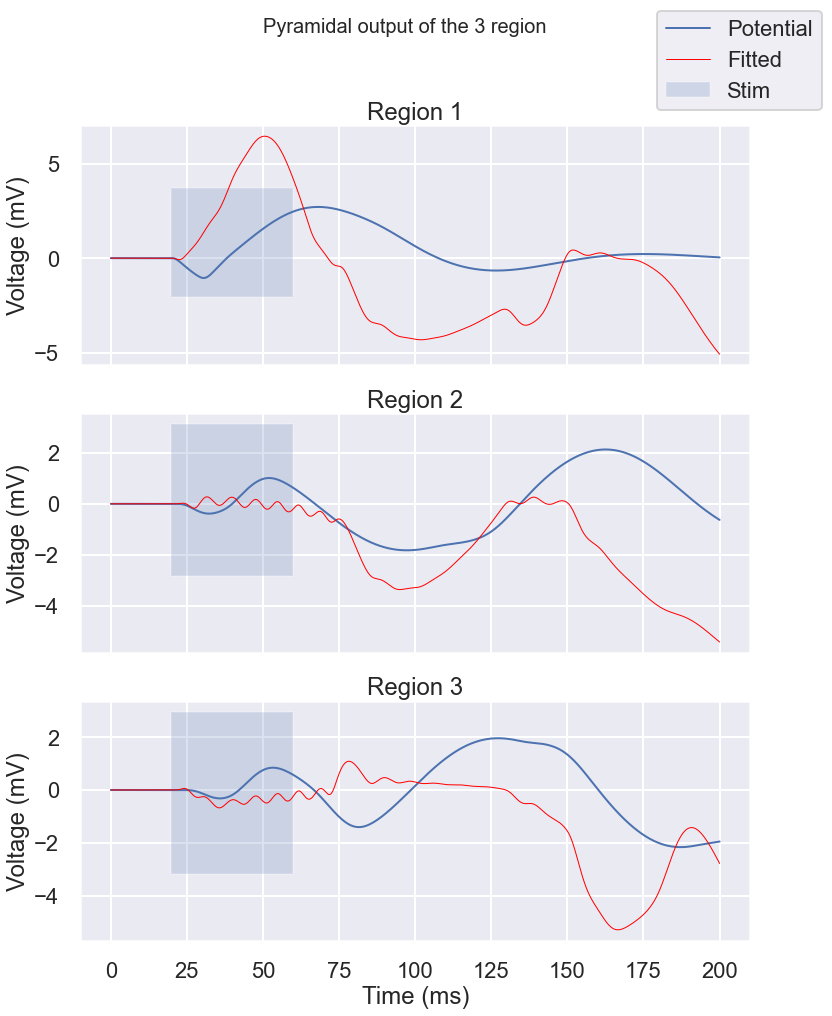

In [194]:
fig ,ax = plt.subplots(region.shape[0],1,figsize=(12,5*3),sharex=True)
for i in range(region.shape[0]):
    ax[i].plot(ts,region[i,8,:],lw=2)
    ax[i].plot(ts,region_meanfit[i,8,:],lw=1,color='red')
    ax[i].fill_between(ts[start_stim:end_stim],(max(region[i,8,:]+1)),(min(region[i,8,:]-1)),alpha=.2,label="Stim")
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle("Pyramidal output of the 3 region",fontsize=20)
fig.legend(labels=["Potential","Fitted","Stim"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_mean_fitted_3regions_1k.png"), dpi=800)
plt.show()

#### Fitted With the Map methode :

In [118]:
MAP = posterior_peaks(torch.as_tensor(theta_posterior),   return_dict=True, labels=theta_label)
MAP_vals= np.array(list(MAP.values())) 
MAP_vals

array([0.47037811, 0.42767817, 0.55124009, 0.6953934 , 0.46776971,
       0.55086264, 0.78181459, 0.55072975, 0.40744301, 0.38737826,
       0.36684433, 0.36326255, 0.07028379, 0.59048228, 0.61206246,
       0.27837744, 0.26144971, 0.53106513, 0.23967158, 0.30553396,
       0.4483731 , 0.28611918, 0.44897911, 0.46946282, 0.46940392,
       0.4295288 , 0.59132265])

In [119]:
# implementing in the model the best values found from the posterior
sig=0
eps=0
region_map,stim_par = DCM_Region(MAP_vals, constants, x_init, sig, eps, dt, ts,input_par)
region_map=region_map.reshape(nr,nn,nt)

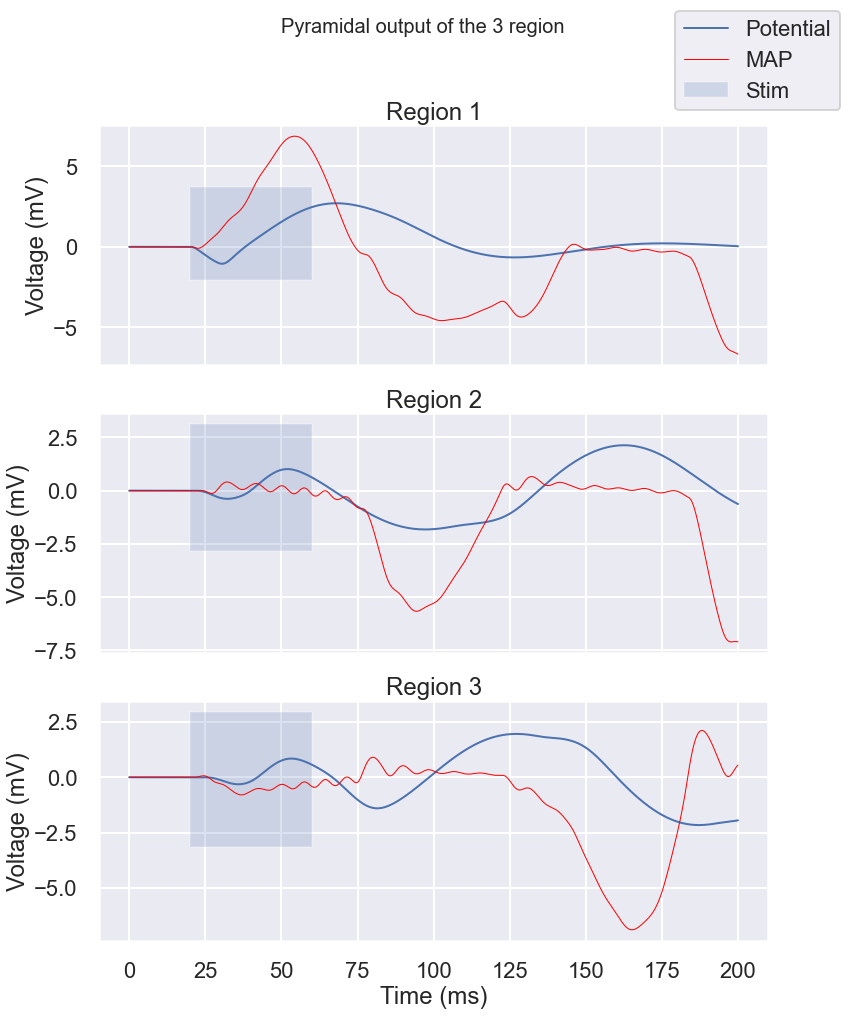

In [195]:
fig ,ax = plt.subplots(region.shape[0],1,figsize=(12,5*3),sharex=True)
for i in range(region.shape[0]):
    ax[i].plot(ts,region[i,8,:],lw=2)
    ax[i].plot(ts,region_map[i,8,:],lw=1,color='red')
    ax[i].fill_between(ts[start_stim:end_stim],(max(region[i,8,:]+1)),(min(region[i,8,:]-1)),alpha=.2,label="Stim")
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle("Pyramidal output of the 3 region",fontsize=20)
fig.legend(labels=["Potential","MAP","Stim"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MAP_fitted_3regions_1k.png"), dpi=800)
plt.show()

#### Fitted between for 95% confiance intervalle :

In [136]:
theta_est_ppc=np.percentile(theta_posterior, [5, 95], axis=0)
xs_fitted_ppc_low_,stim_par=DCM_Region(theta_est_ppc[0,:], constants, x_init, sig, eps, dt, ts,input_par)
xs_fitted_ppc_hi_,stim_par=DCM_Region(theta_est_ppc[1,:], constants, x_init, sig, eps, dt, ts,input_par)
xs_fitted_ppc_low=xs_fitted_ppc_low_.reshape(nr,nn,nt)
xs_fitted_ppc_hi=xs_fitted_ppc_hi_.reshape(nr,nn,nt)

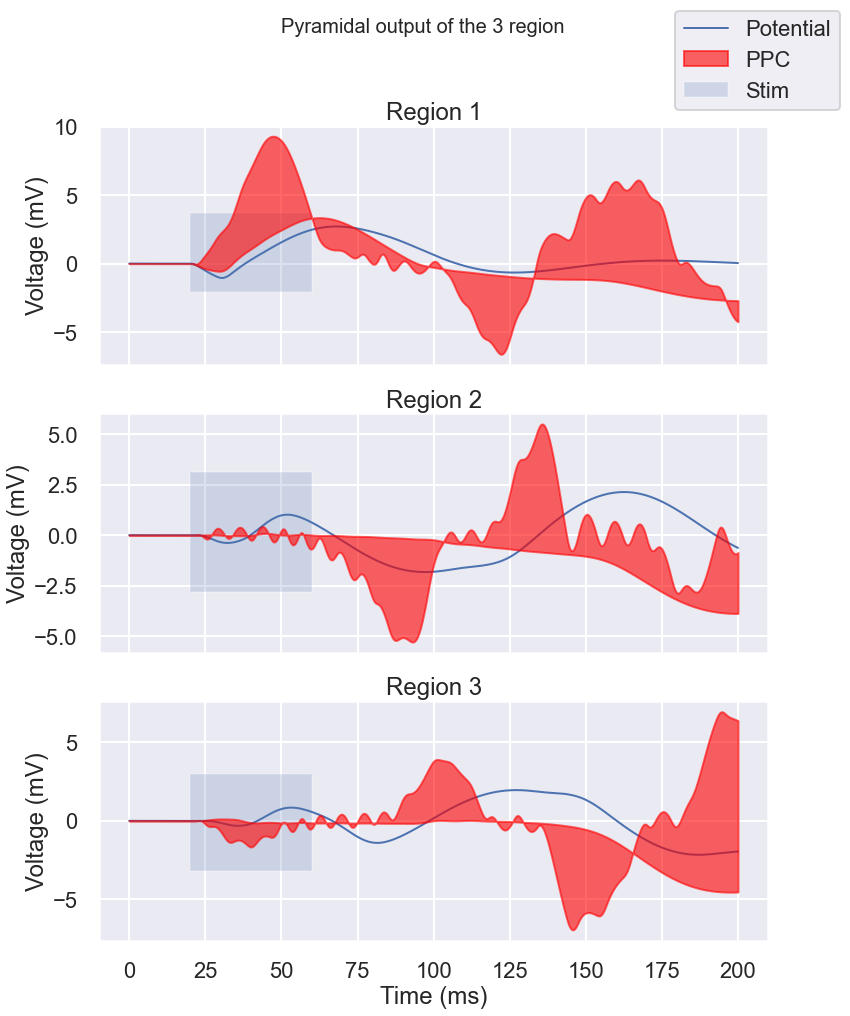

In [196]:
fig ,ax = plt.subplots(region.shape[0],1,figsize=(12,5*3),sharex=True)
for i in range(region.shape[0]):
    ax[i].plot(ts,region[i,8,:],lw=2)
    ax[i].fill_between(ts, xs_fitted_ppc_low[i,8,:], xs_fitted_ppc_hi[i,8,:], color='red', alpha=.6, zorder=8, label='PPC') 
    ax[i].fill_between(ts[start_stim:end_stim],(max(region[i,8,:]+1)),(min(region[i,8,:]-1)),alpha=.2,label="Stim")
    ax[i].set_title(f"Region {i+1}")
    ax[i].set_ylabel("Voltage (mV)")
ax[i].set_xlabel("Time (ms)")
fig.suptitle("Pyramidal output of the 3 region",fontsize=20)
fig.legend(labels=["Potential","PPC","Stim"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_PPC_fitted_3regions_1k.png"), dpi=800)
plt.show()

#### Sensitivity measure :

In [139]:
sensitivity = ActiveSubspace(posterior.set_default_x(obs_features))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples: 1052it [00:06, 153.38it/s]                         


In [140]:
print("Eigenvalues: \n", e_vals, "\n")
#print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([3.0167e-07, 3.2512e-07, 3.6643e-07, 4.0355e-07, 4.1488e-07, 4.4843e-07,
        4.8906e-07, 4.9110e-07, 5.1259e-07, 5.4309e-07, 5.7018e-07, 5.8994e-07,
        6.0525e-07, 6.2940e-07, 6.7716e-07, 7.0737e-07, 7.5259e-07, 7.6958e-07,
        8.4220e-07, 8.7732e-07, 9.3485e-07, 1.1514e-06, 1.2414e-06, 1.5110e-06,
        1.9195e-06, 2.0962e-06, 2.8046e-06]) 



In [143]:
sensitivity_vals = pd.Series(e_vals/min(e_vals), index=theta_label)

df_sensitivity = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df_sensitivity = df_sensitivity.sort_values(by='sensitivity_vals')

my_range=list(range(1,len(df_sensitivity.index)+1))
df_sensitivity

,sensitivity_vals
F Reg 11,1.000000
F Reg 12,1.077748
F Reg 13,1.214684
F Reg 21,1.337729
F Reg 22,1.375289
F Reg 23,1.486502
F Reg 31,1.621173
F Reg 32,1.627930
F Reg 33,1.699189
B Reg 11,1.800286


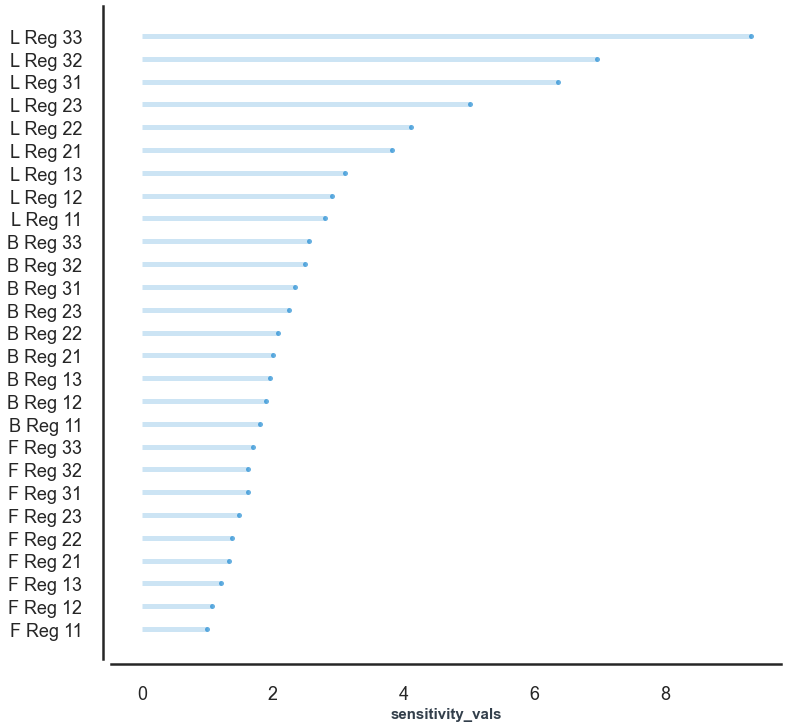

In [146]:
fig, ax = plt.subplots(figsize=(12,12))

plt.hlines(y=my_range, xmin=0, xmax=df_sensitivity['sensitivity_vals'], color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(df_sensitivity['sensitivity_vals'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df_sensitivity.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Sensitivity_vals_ERP_ODE_obs3.png"), dpi=300)
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Sensitivity_vals_ERP_ODE_obs3.svg"), dpi=300) 

plt.show()
# Not sure about the signification of those values 